In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import bmi_cfe

# 1. Run Normal CFE Simulations

In [2]:
cfe_instance = bmi_cfe.BMI_CFE('./cat58_config_cfe.json')
cfe_changing = bmi_cfe.BMI_CFE('./cat58_config_cfe.json')

In [3]:
cfe_instance.initialize()
cfe_changing.initialize()

In [4]:
np.random.seed(0)

In [5]:
with open(cfe_instance.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
outputs = cfe_instance.get_output_var_names()
outputs_changing = cfe_changing.get_output_var_names()

output_lists = {output:[] for output in outputs}
output_lists_changing = {output:[] for output in outputs_changing}

sm_hist = []

for precip in df_forcing['APCP_surface']:
    
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_changing.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    cfe_instance.update()
    
    sm_w_error = cfe_instance.get_value('SOIL_CONCEPTUAL_STORAGE') * np.random.normal(1, 0.03, 1)[0] # added noise to check if it produces different output.
    sm_hist.append(sm_w_error) # to track the states
    cfe_changing.set_value('SOIL_CONCEPTUAL_STORAGE', sm_w_error)
    cfe_changing.update()

    for output in outputs:
    
        output_lists[output].append(cfe_instance.get_value(output))
        output_lists_changing[output].append(cfe_changing.get_value(output))

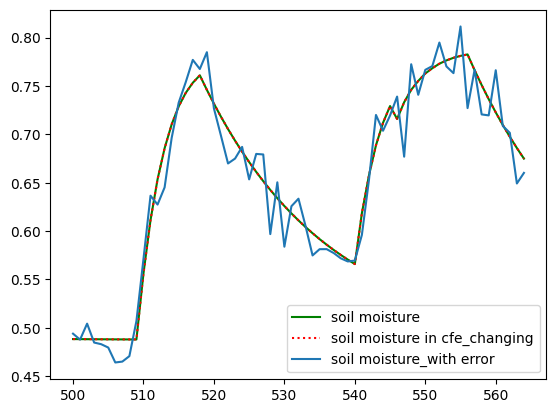

In [6]:
plt.plot(df_forcing.index.values[500:565], output_lists['SOIL_CONCEPTUAL_STORAGE'][500:565], c="g", label="soil moisture")
plt.plot(df_forcing.index.values[500:565], output_lists_changing['SOIL_CONCEPTUAL_STORAGE'][500:565], c="r",linewidth = 1.5, linestyle = ':', label="soil moisture in cfe_changing")
plt.plot(df_forcing.index.values[500:565], sm_hist[500:565], label="soil moisture_with error")
plt.legend()

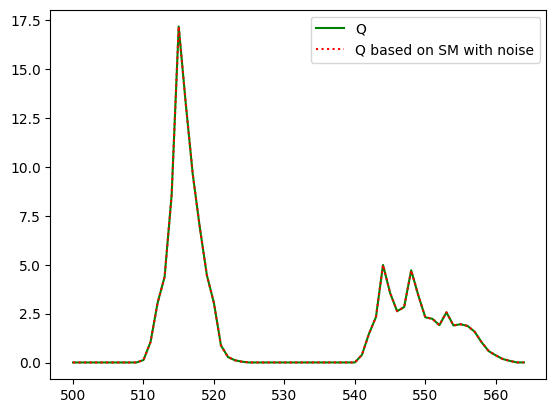

In [7]:
plt.plot(df_forcing.index.values[500:565], output_lists['land_surface_water__runoff_depth'][500:565], c="g", label="Q")
plt.plot(df_forcing.index.values[500:565], output_lists_changing['land_surface_water__runoff_depth'][500:565], c="r",linewidth = 1.5, linestyle = ':', label="Q based on SM with noise")
plt.legend()

In [8]:
cfe_instance.finalize(print_mass_balance=True)


GLOBAL MASS BALANCE
  initial volume:   0.7456
    volume input: 259.2000
   volume output: 247.8860
    final volume:   1.4450
        residual: -1.3856e-13

PARTITION MASS BALANCE
    surface runoff: 256.5086
      infiltration:   2.6914
 vol. et from rain:   0.0000
partition residual: 2.4425e-14

GIUH MASS BALANCE
  vol. into giuh: 256.5086
   vol. out giuh: 245.8940
 vol. end giuh q:  10.6146
   giuh residual: -2.3093e-13

SOIL WATER MASS BALANCE
     init soil vol:   0.5856
    vol. into soil:   2.6914
  vol.soil2latflow:   1.1298
   vol. soil to gw:   1.3747
 vol. et from soil:   0.0000
   final vol. soil:   0.7726
  vol. soil resid.: 0.0000e+00

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   1.1298
  vol. from nash:   0.9143
 final vol. nash:   0.2155
nash casc resid.: 1.0547e-15

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.1600
       vol to gw:   1.3747
     vol from gw:   0.8622
final gw.storage:   0.6725
    gw. residual: 4.4409e-